# Peprocessing 

This notebook contains code for understanding the preprocessing steps implemented on the raw data used in the project: Public attitudes and ethical guidelines in digital field experiments (digex).

The data file has been anonymized (i.e. participants' IP address, Qualtrics ID, and Prolific ID have been removed). Hence the dataset currently does not contain a participant_id column; the index can instead be used to locate particular rows.

## Set working directory

In [1]:
import pathlib   # Change cwd
import os 

path = pathlib.Path.cwd().parent
os.chdir(path)

## Imports

In [2]:
import yaml   # 3rd party packages
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport

from digex_src import config    # Local imports
from digex_src import preprocess
from digex_src.load_data import get_data_filepath

warnings.filterwarnings('ignore')    # Ignore warnings

## Load raw data

In [3]:
digex_raw_data_path = get_data_filepath(main=False) 
digex_raw_data_df = pd.read_excel(digex_raw_data_path)

digex_raw_data_df.head()

start_date             end_date         status  progress  \
0           Start Date             End Date  Response Type  Progress   
1  2022-09-09 04:23:23  2022-09-09 04:38:35     IP Address       100   
2  2022-09-09 04:34:03  2022-09-09 04:46:03     IP Address       100   
3  2022-09-09 04:34:26  2022-09-09 05:05:41     IP Address       100   
4  2022-09-09 04:51:43  2022-09-09 05:12:47     IP Address       100   

            duration_sec  finished                        date  \
0  Duration (in seconds)  Finished               Recorded Date   
1                    912      True  2022-09-09 04:38:37.488000   
2                    720      True  2022-09-09 04:46:04.146000   
3                   1874      True  2022-09-09 05:05:43.065000   
4                   1264      True  2022-09-09 05:12:47.820000   

   q_recaptcha_scor                                            consent  \
0  Q_RecaptchaScore  Welcome to our survey! \n\nStudy Information a...   
1               0.9                                          I consent   
2               0.8                                          I consent   
3               0.9                                          I consent   
4               0.9                                          I consent   

                                              sm_use  ...  \
0  Which of the following social media sites do y...  ...   
1                                           Facebook  ...   
2                                            Twitter  ...   
3                                           Facebook  ...   
4                                           Facebook  ...   

                                          rank_anony  \
0  To run experiments like the ones described in ...   
1                                                  6   
2                                                  6   
3                                                  3   
4                                                  3   

                                          rank_harms  \
0  To run experiments like the ones described in ...   
1                                                  4   
2                                                  1   
3                                                  2   
4                                                  4   

                                        rank_balance  \
0  To run experiments like the ones described in ...   
1                                                  3   
2                                                  7   
3                                                  4   
4                                                  5   

                                    rank_pub_interst  \
0  To run experiments like the ones described in ...   
1                                                  1   
2                                                  4   
3                                                  1   
4                                                  1   

                                      rank_add_fac_1  \
0  Are there any additional factors that you thin...   
1                                                NaN   
2                                                NaN   
3                                                 Na   
4                      Offer results to participants   

                                  rank_add_fac_1_pos  \
0  Are there any additional factors that you thin...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                  8   

                                      rank_add_fac_2  \
0  Are there any additional factors that you thin...   
1                                                NaN   
2                                                NaN   
3                                                 Na   
4                                                NaN   

           

## Understanding the raw data

### Columns

**Respondent Information**

> The first several columns in a dataset include information about each respondent and their response, such as IP address, response submission dates, and so on. Most of these have been excluded from the raw dataset used for anonymisation purposes. 

**Question Responses**

> The next columns in the data set display the answers provided for each survey question. Columns are headed with the question numbers (e.g., Q1).
Simple questions (text entry, multiple choice – one answer, etc.) are contained in one column, but more complex questions with multiple statements (matrix table, side by side, etc.) are spread across multiple columns (i.e., Q2, Q3, Q4, Q24, Q26, Q27). For example, for question 2, 'How do you describe yourself?', which is multipls choice, the raw dataset has one column ('Q2') containing the value counts for each of the four provided choices ('Male', 'Female', 'Non-binary / third gender', 'Prefer not to say') and another column ('Q2_4_TEXT') containing the value counts for the text entry option ('Prefer to self-describe). 

Source: Qualtrics. (2022). _Understanding Your Data Set_. Available at:https://www.qualtrics.com/support/survey-platform/data-and-analysis-module/data/download-data/understanding-your-dataset/

### Profiling report

Pandas profiling reports for the raw and processed datasets can be found in the `reports/` directory

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

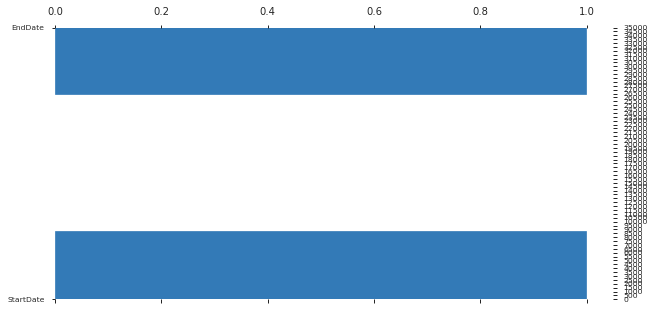

In [3]:
# Generate a pandas profiling report of raw survey responses
profile = preprocess_data.generate_profiling_report(
    raw_data_df, notebook=True
)

# View report in notebook
profile.to_notebook_iframe()  

## Preprocessing the data

The following preprocessing steps are implemented in the script `preprocess.py`

- `generate_reports()` optionally creates pandas profiling reports for the raw and processed datasets, which are saved to the reports/ directory.
- unncessary respondent information columns are dropped (see `drop()`)
- data types for columns are declared (e.g., the pandas `category` dtype is used for likert variables; see `assign_dtypes()`)
- missing values are consistently recorded as `NaN`
- 3 new columns are created to record participants 'scores' for the awareness section variables `aware_sm_advan`, `aware_sm_interact`, and `aware_sm_use` (see variable table below for full variable names). For each variable, the
`AWARE_ANSWERS` dictionary in the `digex_src/config.py` is used to count how many correct and incorrect answers participants
guessed. For example, for question 8. _Sometimes academic researchers run online experiments on social media sites that involve interacting with users. Which of the following ways of interacting on social media do you think academics have used in their experiments? (Select all that apply_ (coded as `aware_sm_interact`), participants recieve 1 point for every correct choice selected from the multiple choice options and -1 for every incorrect answer (see the `AWARE_ANSWERS` dictionary for a list of the correct and incorrect answers). The final score is recorded in the column `aware_sm_interact_score`. The same is done for the other two awareness section variables.  
- a variable defintions table is generated (which is displayed at the botttom of this notebook). 
- the processed file (displayed below) is saved to the data/processsed/ directory as a CSV.

Note that some parameters (e.g. where outputs are saved) can be easily changed by manipulating the global variables (e.g. `REPORTS_DIR`) declared in the `config.py` file.

### Load preprocessed data

In [5]:
processed_data_path = get_data_filepath(
    file=config.PROCESSED_DATA_FILEPATH, 
    data_path=config.PROCESSED_DATA_DIR,
    main=False
) 

digex_df = pd.read_csv(processed_data_path, index_col=0)

digex_df.head()

sm_use   age gender_id          ethnic_id                edu  \
1  Facebook  29.0      Male    Asian - Eastern         Highschool   
2   Twitter  33.0      Male         Mixed race         Highschool   
3  Facebook  33.0    Female   Pacific Islander  Bachelor's degree   
4  Facebook  73.0    Female  White / Caucasian         Highschool   
5   Twitter  27.0    Female    Native-American         Highschool   

                              politic_views      aware_sm_res  \
1                          Slightly liberal   Extremely aware   
2  Neutral/ Neither conservative or liberal  Moderately aware   
3                              Very liberal   Extremely aware   
4                     Slightly conservative  Moderately aware   
5                              Very liberal   Extremely aware   

                                      aware_sm_advan  \
1  ['… are large and can contain millions of data...   
2  ['… are large and can contain millions of data...   
3  ['… are large and can contain millions of data...   
4  ['… are large and can contain millions of data...   
5  ['… often capture social relationships not fou...   

                                   aware_sm_interact  \
1  ['Creating fake accounts ("bots")', 'Secretly ...   
2  ['Privately messaging users', "Publicly postin...   
3  ['Privately messaging users', "Publicly postin...   
4                ['Creating fake accounts ("bots")']   
5  ['Privately messaging users', "Publicly postin...   

                                        aware_sm_use  ... rank_pub_interst  \
1  ['Political elections (e.g. voting behavior)',...  ...              1.0   
2  ['Political elections (e.g. voting behavior)',...  ...              4.0   
3  ['Political elections (e.g. voting behavior)',...  ...              1.0   
4  ['Political elections (e.g. voting behavior)',...  ...              1.0   
5  ['Political elections (e.g. voting behavior)',...  ...              7.0   

  rank_add_fac_1 rank_add_fac_1_pos rank_add_fac_2 rank_add_fac_2_pos  \
1            NaN                NaN            NaN                NaN   
2            NaN                NaN            NaN                NaN   
3            NaN                NaN            NaN                NaN   
4            NaN                8.0            NaN                NaN   
5            NaN                NaN            NaN                NaN   

  rank_add_fac_3 rank_add_fac_3_pos aware_sm_advan_score  \
1            NaN                NaN                    4   
2            NaN                NaN                    1   
3            NaN                NaN                    2   
4            NaN                NaN                    1   
5            NaN                NaN                    0   

  aware_sm_interact_score aware_sm_use_score  
1                       0                  9  
2                       1                  9  
3                       2                  5  
4                       1                  6  
5                       3                  9  

[5 rows x 49 columns]

#### Table 1. Variable names

In [6]:
from IPython.display import HTML

HTML(filename='../reports/variable-table.html')